In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
#1 Import du fichier avec l'encodage spécifié
df = pd.read_csv('AviationData.csv', encoding='mac_roman')

In [3]:
#2 Créer un DataFrame avec des informations sur les colonnes
# Initialiser le DataFrame de résumé
resume_df = pd.DataFrame({
    'Nom_Colonne': df.columns,
    'Valeurs_Manquantes': df.isna().sum().values,
    'Type_Donnees': df.dtypes.astype(str).values
})

# Afficher le DataFrame de résumé
print(resume_df)

               Nom_Colonne  Valeurs_Manquantes Type_Donnees
0                 Event.Id                   0       object
1       Investigation.Type                   0       object
2          Accident.Number                   0       object
3               Event.Date                   0       object
4                 Location                  52       object
5                  Country                 226       object
6                 Latitude               54209       object
7                Longitude               54218       object
8             Airport.Code               38065       object
9             Airport.Name               35412       object
10         Injury.Severity                 883       object
11         Aircraft.damage                3010       object
12       Aircraft.Category               56499       object
13     Registration.Number                1382       object
14                    Make                  63       object
15                   Model              

In [4]:
#Modification des type de données
df['Event.Date'] = pd.to_datetime(df['Event.Date'], errors='coerce')
df['Publication.Date'] = pd.to_datetime(df['Publication.Date'], errors='coerce')

In [5]:
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

In [6]:
# Colonnes catégorielles
categorical_cols = [
    'Investigation.Type', 'Injury.Severity', 'Aircraft.damage',
    'Aircraft.Category', 'Make', 'Model', 'Amateur.Built',
    'Engine.Type', 'FAR.Description', 'Schedule', 'Purpose.of.flight',
    'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status'
    ]
    
for col in categorical_cols:
 if col in df.columns:
   df[col] = df[col].astype('category')

In [7]:
#3 Appliquer la fonction describe
print (df.describe())

                          Event.Date      Latitude     Longitude  \
count                          87282  1.198200e+04  1.197000e+04   
mean   1999-04-17 13:10:44.669003904  2.500714e+03  2.653796e+04   
min              1948-10-24 00:00:00 -7.801695e+01 -1.742967e+02   
25%              1988-11-03 00:00:00  3.344139e+01 -1.162268e+02   
50%              1998-04-03 00:00:00  3.816194e+01 -9.548500e+01   
75%              2008-10-02 18:00:00  4.255764e+01 -8.202049e+01   
max              2022-12-08 00:00:00  7.302524e+06  5.965231e+07   
std                              NaN  1.076162e+05  1.200881e+06   

       Number.of.Engines  Total.Fatal.Injuries  Total.Serious.Injuries  \
count       81533.000000          75881.000000            74772.000000   
mean            1.147131              0.652772                0.280921   
min             0.000000              0.000000                0.000000   
25%             1.000000              0.000000                0.000000   
50%             1

In [8]:
# Suppression des colonnes avec trop de valeurs manquantes
SupCol = [
    'Latitude', 'Longitude', 'Airport.Code', 'Airport.Name',
    'Aircraft.Category', 'FAR.Description', 'Schedule', 
    'Air.carrier', 'Publication.Date'
]
df = df.drop(columns=SupCol, errors='ignore')

In [9]:
#SUPPRESSION DES LIGNES AVEC PEU DE VALEURS MANQUANTES
# Supprimer les lignes où les colonnes on peux de valeur manquante la raison est que ces colonnes ont très peu de valeurs manquantes 
#ces colonnes sont considérées comme importantes pour l'analyse 
df = df.dropna(subset=['Location', 'Country', 'Make', 'Model', 'Amateur.Built'])

In [10]:
#5 CONVERSION DE LA COLONNE EVENT.DATE EN DATETIME

df['Event.Date'] = pd.to_datetime(df['Event.Date'], errors='coerce')

In [11]:
#6 AJOUT DE LA COLONNE YEAR 

df['Year'] = df['Event.Date'].dt.year

In [12]:
#7 GROUPBY PAR ANNÉE ET COMPTAGE DES ACCIDENTS

Accidents = df.groupby('Year', as_index=False)['Event.Id'].count()
Accidents.columns = ['Year', 'Nombre_Accidents']
print (Accidents)

    Year  Nombre_Accidents
0   1948                 1
1   1962                 1
2   1974                 1
3   1977                 1
4   1979                 2
5   1981                 1
6   1982              3562
7   1983              3534
8   1984              3438
9   1985              3082
10  1986              2868
11  1987              2810
12  1988              2715
13  1989              2530
14  1990              2501
15  1991              2448
16  1992              2339
17  1993              2305
18  1994              2245
19  1995              2297
20  1996              2177
21  1997              2137
22  1998              2207
23  1999              2194
24  2000              2205
25  2001              2044
26  2002              2010
27  2003              2070
28  2004              1939
29  2005              2010
30  2006              1819
31  2007              1995
32  2008              1887
33  2009              1770
34  2010              1778
35  2011              1842
3

In [13]:
#8 FILTRAGE DES ANNÉES 1982-2020

Accidents = Accidents[(Accidents['Year'] >= 1982) & (Accidents['Year'] <= 2020)]

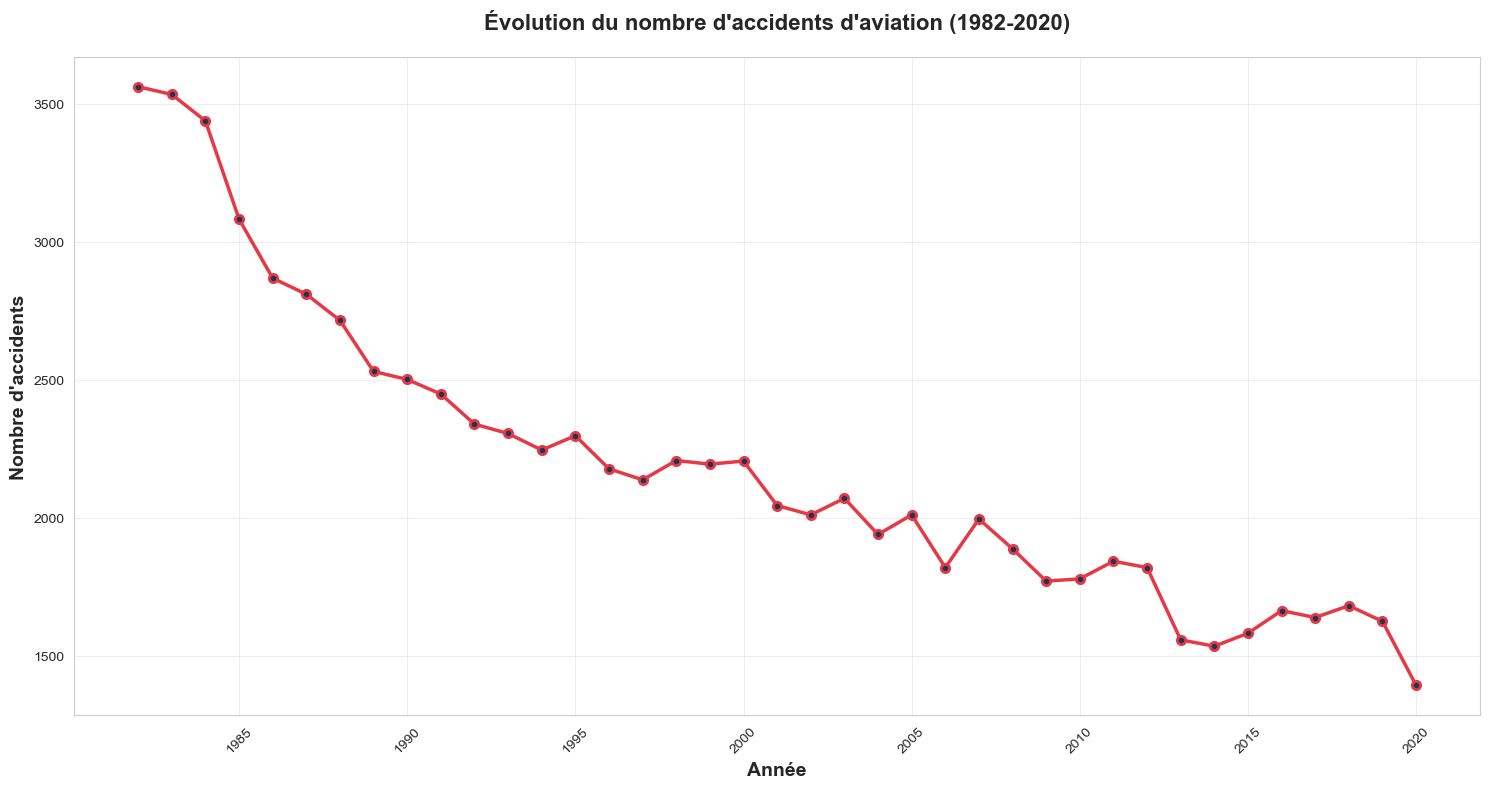

In [14]:
#9 GRAPHIQUE LINÉAIRE DES ACCIDENTS PAR ANNÉE

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.plot(Accidents['Year'], Accidents['Nombre_Accidents'], 
         marker='o', linewidth=2.5, markersize=6, 
         color='#E63946', markerfacecolor='#1D3557', markeredgewidth=2)

plt.xlabel('Année', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'accidents', fontsize=14, fontweight='bold')
plt.title('Évolution du nombre d\'accidents d\'aviation (1982-2020)', 
          fontsize=16, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

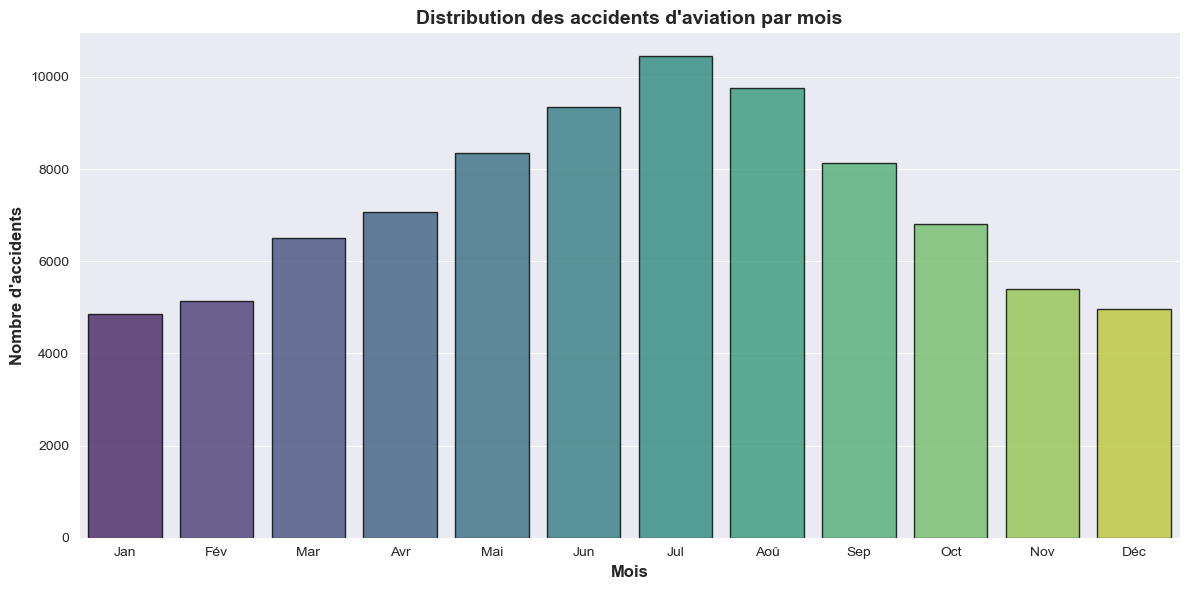

In [15]:
#10 EXTRACTION DES MOIS ET GRAPHIQUE EN BARRES 

df['Month.Abbr'] = df['Event.Date'].dt.month

accidents_par_mois = df.groupby('Month.Abbr', as_index=False)['Event.Id'].count()
accidents_par_mois.columns = ['Mois', 'Nombre_Accidents']

plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

sns.barplot(data=accidents_par_mois, x='Mois', y='Nombre_Accidents', 
            palette='viridis', alpha=0.8, edgecolor='black')

plt.xlabel('Mois', fontsize=12, fontweight='bold')
plt.ylabel('Nombre d\'accidents', fontsize=12, fontweight='bold')
plt.title('Distribution des accidents d\'aviation par mois', 
          fontsize=14, fontweight='bold')

mois_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
               'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
plt.xticks(ticks=range(12), labels=mois_labels)
plt.tight_layout()
plt.show()

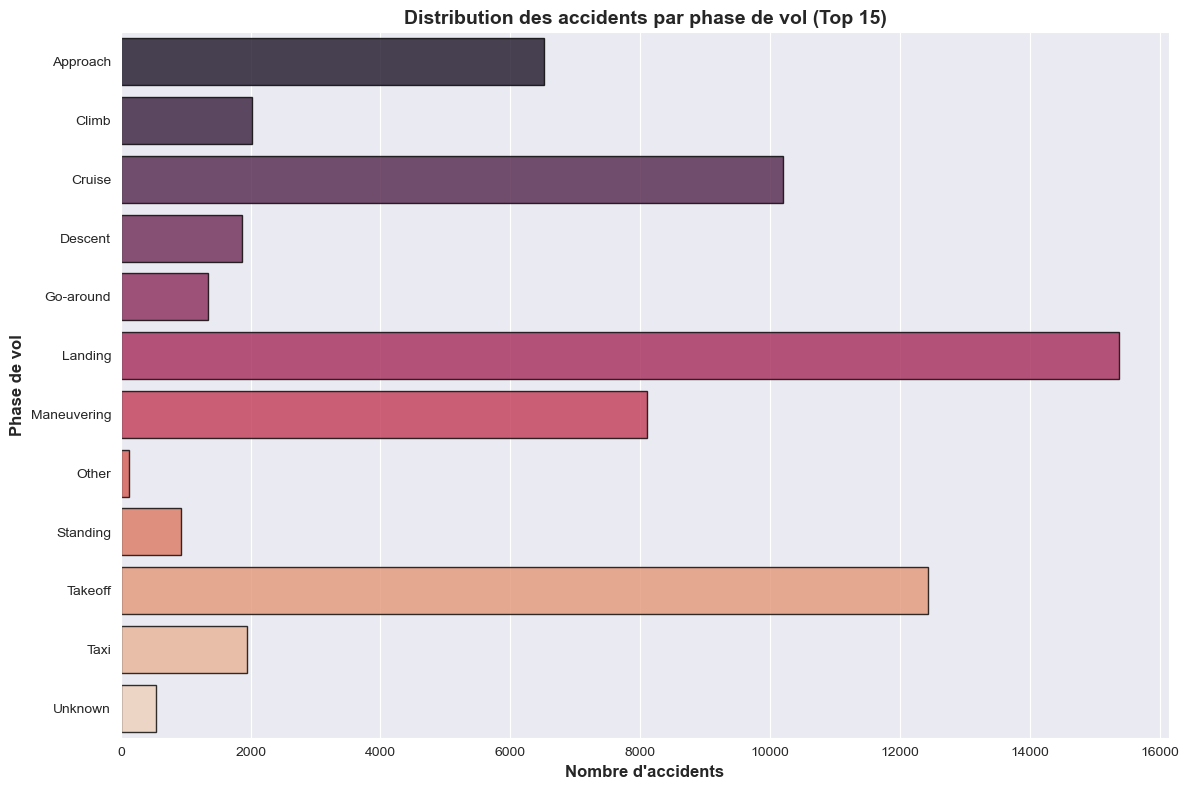

In [16]:
#11. GRAPHIQUE EN BARRES PAR PHASE DE VOL

plt.figure(figsize=(12, 8))
phase_vol_counts = df['Broad.phase.of.flight'].value_counts().head(15)

sns.barplot(x=phase_vol_counts.values, y=phase_vol_counts.index, 
            palette='rocket', alpha=0.8, edgecolor='black')

plt.xlabel('Nombre d\'accidents', fontsize=12, fontweight='bold')
plt.ylabel('Phase de vol', fontsize=12, fontweight='bold')
plt.title('Distribution des accidents par phase de vol (Top 15)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
#12 DATAFRAME DES TYPES D'INCIDENTS PAR ANNÉE


incidents_par_an = df.groupby('Year').agg({
    'Total.Fatal.Injuries': 'sum',
    'Total.Serious.Injuries': 'sum',
    'Total.Minor.Injuries': 'sum'
}).reset_index()

# Filtrage des années
incidents_par_an = incidents_par_an[
    (incidents_par_an['Year'] >= 1982) & 
    (incidents_par_an['Year'] <= 2020)
]


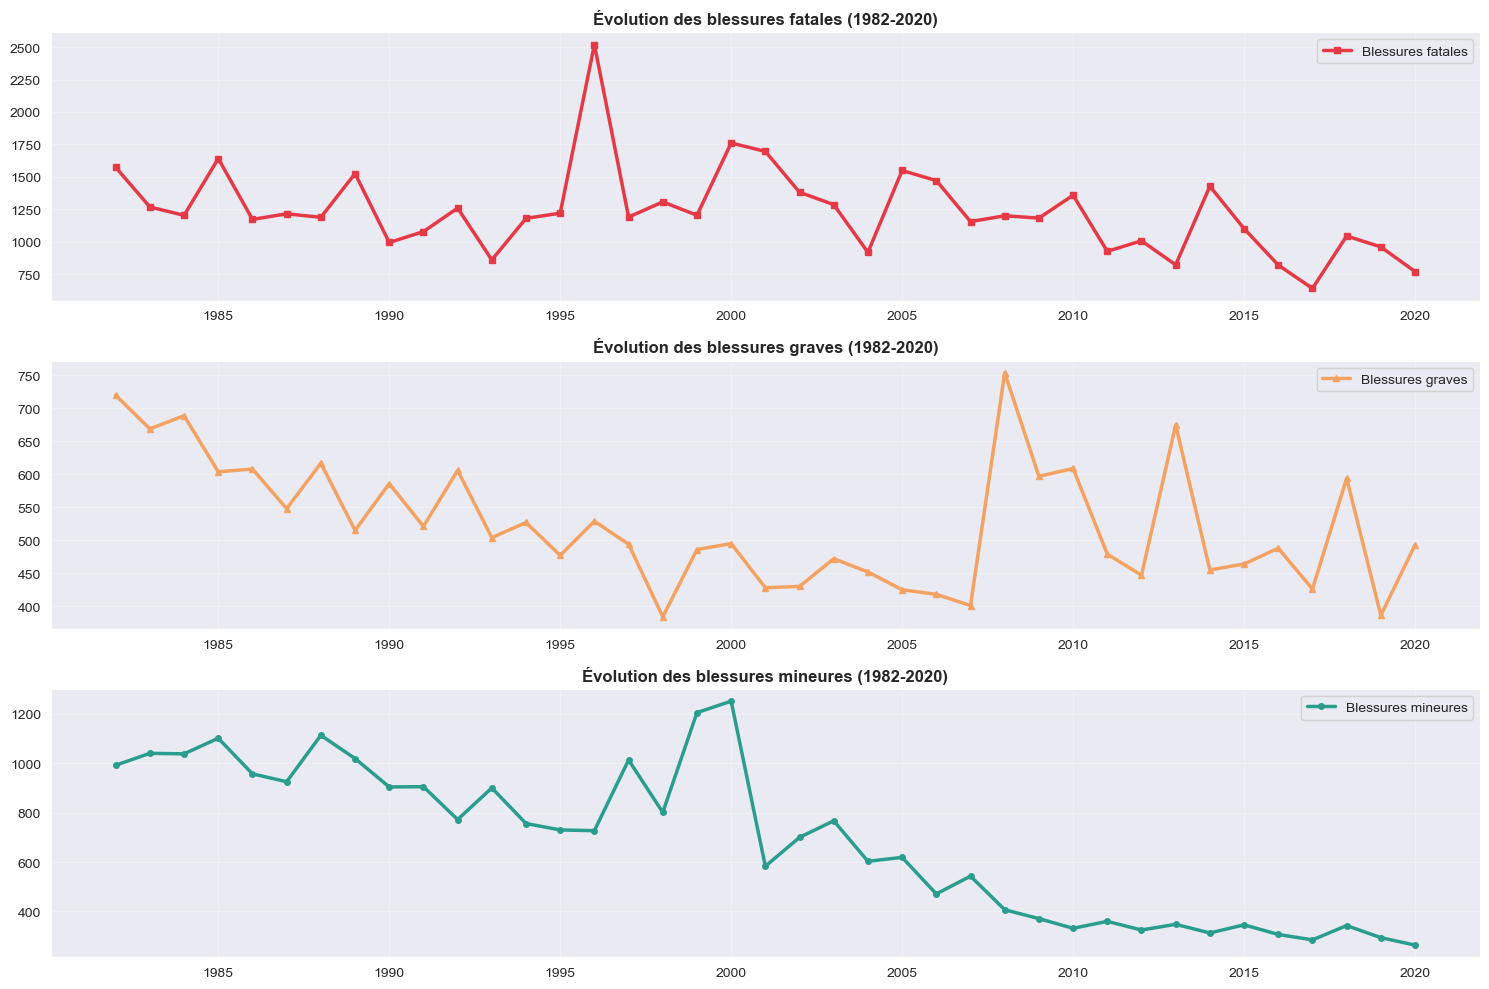

In [18]:
# Graphiques linéaires multiples
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(incidents_par_an['Year'], incidents_par_an['Total.Fatal.Injuries'], 
         marker='s', color='#E63946', linewidth=2.5, markersize=4, label='Blessures fatales')
plt.title('Évolution des blessures fatales (1982-2020)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(incidents_par_an['Year'], incidents_par_an['Total.Serious.Injuries'], 
         marker='^', color='#F4A261', linewidth=2.5, markersize=4, label='Blessures graves')
plt.title('Évolution des blessures graves (1982-2020)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(incidents_par_an['Year'], incidents_par_an['Total.Minor.Injuries'], 
         marker='o', color='#2A9D8F', linewidth=2.5, markersize=4, label='Blessures mineures')
plt.title('Évolution des blessures mineures (1982-2020)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
#13 Suppression des colonnes non informatives
colonnes_a_supprimer = [
    'Event.Id', 'Accident.Number', 'Registration.Number',
    'Publication.Date', 'Airport.Code', 'Airport.Name',
    'Location', 'Country', 'Latitude', 'Longitude'
]

In [20]:

# Imputation des valeurs manquantes avec SimpleImputer

colonnes_categorielles = df.select_dtypes(include=['object']).columns

imputer_cat = SimpleImputer(strategy='most_frequent')
df[colonnes_categorielles] = imputer_cat.fit_transform(df[colonnes_categorielles])

# Colonnes numériques  
colonnes_numeriques = df.select_dtypes(include=[np.number]).columns

imputer_num = SimpleImputer(strategy='median')
df[colonnes_numeriques] = imputer_num.fit_transform(df[colonnes_numeriques])

# Encodage de la variable cible Aircraft.damage
df['Aircraft.damage'] = df['Aircraft.damage'].map({
    'Minor': 0, 
    'Substantial': 1, 
    'Destroyed': 2
})

#Extraction des noms des colonnes catégorielles
colonnes_categorielles_ml = df.select_dtypes(include=['object']).columns.tolist()
print("Colonnes catégorielles identifiées:", colonnes_categorielles_ml)

# Encodage par étiquette avec LabelEncoder
encodeurs = {}
for colonne in colonnes_categorielles_ml:
    encodeur = LabelEncoder()
    df[colonne] = encodeur.fit_transform(df[colonne].astype(str))
    encodeurs[colonne] = encodeur

Colonnes catégorielles identifiées: ['Event.Id', 'Accident.Number', 'Location', 'Country', 'Registration.Number']


In [21]:
#14 BOXPLOTS POUR VISUALISER LES DISTRIBUTIONS

colonnes_interet = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                   'Total.Minor.Injuries', 'Total.Uninjured', 'Number.of.Engines']

if all(col in df_ml.columns for col in colonnes_interet):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, colonne in enumerate(colonnes_interet):
        df[colonne].plot(kind='box', ax=axes[i], vert=True, patch_artist=True)
        axes[i].set_title(f'Distribution de {colonne}', fontweight='bold')
    
    # Masquer le dernier subplot vide si nécessaire
    if len(colonnes_interet) < 6:
        for i in range(len(colonnes_interet), 6):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

NameError: name 'df_ml' is not defined

In [ ]:
#15 DÉTECTION ET GESTION DES OUTLIERS 

Discrete_Columns = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                   'Total.Minor.Injuries', 'Total.Uninjured', 'Number.of.Engines']

print("=== Statistiques avant traitement des outliers ===")
print(df[Discrete_Columns].describe())

# Méthode IQR pour détection des outliers
def traiter_outliers_iqr(dataframe, colonnes):
    df_out = dataframe.copy()
    resume_outliers = {}
    
    for col in colonnes:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        borne_inf = Q1 - 1.5 * IQR
        borne_sup = Q3 + 1.5 * IQR
        
        # Winsorization
        df_out[col] = np.clip(df_out[col], borne_inf, borne_sup)
        
        resume_outliers[col] = {
            'IQR': IQR,
            'Borne_Inf': borne_inf,
            'Borne_Sup': borne_sup
        }
    
    return df_out, resume_outliers

df_sans_outliers, info_outliers = traiter_outliers_iqr(df, Discrete_Columns)

print("\n=== Statistiques après traitement des outliers ===")
print(df_sans_outliers[Discrete_Columns].describe())

# Résumé final
print(f"\n=== SYNTHÈSE DU TRAITEMENT ===")
print(f"Dataset après préparation ML: {df.shape}")
print(f"Colonnes catégorielles encodées: {len(colonnes_categorielles_ml)}")
print(f"Valeurs manquantes restantes: {df.isnull().sum().sum()}")

In [20]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 86799 entries, 0 to 87281
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                86799 non-null  object        
 1   Investigation.Type      86799 non-null  category      
 2   Accident.Number         86799 non-null  object        
 3   Event.Date              86799 non-null  datetime64[ns]
 4   Location                86799 non-null  object        
 5   Country                 86799 non-null  object        
 6   Injury.Severity         85937 non-null  category      
 7   Aircraft.damage         83849 non-null  category      
 8   Registration.Number     85550 non-null  object        
 9   Make                    86799 non-null  category      
 10  Model                   86799 non-null  category      
 11  Amateur.Built           86799 non-null  category      
 12  Number.of.Engines       81221 non-null  float64    

In [23]:
df.to_csv('AviationData_clean.csv', index=False, sep=';')